# CHAPTER 13

In [ ]:
!pip install tldextract


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 1.9 MB/s eta 0:00:00


In [ ]:
import os, json, math, re, datetime as dt
import numpy as np
import pandas as pd
import pytz
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import tldextract

## 13.1 Bitly Data from 1.USA.gov

In [ ]:
path = "/content/drive/MyDrive/DataAnalysis/Tuần 7/example.txt"
with open(path) as f:
  print(f.readline())

{ "a": "Mozilla\/5.0 (Windows NT 6.1; WOW64) AppleWebKit\/535.11 (KHTML, like Gecko) Chrome\/17.0.963.78 Safari\/535.11", "c": "US", "nk": 1, "tz": "America\/New_York", "gr": "MA", "g": "A6qOVH", "h": "wfLQtf", "l": "orofrog", "al": "en-US,en;q=0.8", "hh": "1.usa.gov", "r": "http:\/\/www.facebook.com\/l\/7AQEFzjSi\/1.usa.gov\/wfLQtf", "u": "http:\/\/www.ncbi.nlm.nih.gov\/pubmed\/22415991", "t": 1331923247, "hc": 1331822918, "cy": "Danvers", "ll": [ 42.576698, -70.954903 ] }



### Đọc dữ liệu

In [ ]:
records = []
with open(path, 'r', encoding='utf-8', errors='replace') as f:
    for i, line in enumerate(f, 1):
        line = line.strip()
        if not line:
            continue
        try:
            records.append(json.loads(line))
        except Exception as e:
            # Bạn có thể log lại nếu muốn
            # print(f"Skip line {i}: {e}")
            pass

df = pd.DataFrame(records)
print("Shape:", df.shape)
df.head()

Shape: (3560, 18)


,a,c,nk,tz,gr,g,h,l,al,hh,r,u,t,hc,cy,ll,_heartbeat_,kw
0,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,US,1.0,America/New_York,MA,A6qOVH,wfLQtf,orofrog,"en-US,en;q=0.8",1.usa.gov,http://www.facebook.com/l/7AQEFzjSi/1.usa.gov/...,http://www.ncbi.nlm.nih.gov/pubmed/22415991,1.331923e+09,1.331823e+09,Danvers,"[42.576698, -70.954903]",NaN,NaN
1,GoogleMaps/RochesterNY,US,0.0,America/Denver,UT,mwszkS,mwszkS,bitly,NaN,j.mp,http://www.AwareMap.com/,http://www.monroecounty.gov/etc/911/rss.php,1.331923e+09,1.308262e+09,Provo,"[40.218102, -111.613297]",NaN,NaN
2,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,US,1.0,America/New_York,DC,xxr3Qb,xxr3Qb,bitly,en-US,1.usa.gov,http://t.co/03elZC4Q,http://boxer.senate.gov/en/press/releases/0316...,1.331923e+09,1.331920e+09,Washington,"[38.9007, -77.043098]",NaN,NaN
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8)...,BR,0.0,America/Sao_Paulo,27,zCaLwp,zUtuOu,alelex88,pt-br,1.usa.gov,direct,http://apod.nasa.gov/apod/ap120312.html,1.331923e+09,1.331923e+09,Braz,"[-23.549999, -46.616699]",NaN,NaN
4,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,US,0.0,America/New_York,MA,9b6kNl,9b6kNl,bitly,"en-US,en;q=0.8",bit.ly,http://www.shrewsbury-ma.gov/selco/,http://www.shrewsbury-ma.gov/egov/gallery/1341...,1.331923e+09,1.273672e+09,Shrewsbury,"[42.286499, -71.714699]",NaN,NaN


###  Làm sạch cột

In [ ]:
# Chuẩn hoá một số cột:
# - 'tz' (múi giờ), 'c' (quốc gia ISO), 'a' (user-agent), 'r' (referrer), 't' (epoch giây)
for col in ["tz", "c", "a", "r", "g", "h", "u", "hc", "t"]:
    if col not in df.columns:
        df[col] = np.nan

df["tz"] = df["tz"].fillna("Missing").replace({"": "Unknown"})
df["c"] = df["c"].fillna("Unknown").replace({"": "Unknown"})

# Ép timestamp -> datetime theo local tz nếu có, fallback UTC.
# Trả về datetime **naive (không tzinfo)** để Series có dtype datetime64[ns]
import datetime as dt
import pytz
import pandas as pd
import numpy as np
import re
from urllib.parse import urlparse
import tldextract

def to_local_dt(row):
    ts = row.get("t", np.nan)
    if pd.isna(ts):
        return np.nan
    try:
        ts = float(ts)
    except Exception:
        return np.nan

    tz_str = row.get("tz", "UTC") or "UTC"
    if tz_str in ["Missing", "Unknown"]:
        tz_str = "UTC"
    try:
        tz = pytz.timezone(tz_str)
    except Exception:
        tz = pytz.UTC

    # Datetime có tz theo múi giờ của từng row
    aware_dt = dt.datetime.fromtimestamp(ts, tz)
    # Chuyển về datetime naive (bỏ tz) để pandas dùng dtype datetime64[ns]
    return pd.Timestamp(aware_dt).tz_localize(None)

df["dt_local"] = df.apply(to_local_dt, axis=1)
# Ép kiểu lần nữa để chắc chắn là datetime64[ns]
df["dt_local"] = pd.to_datetime(df["dt_local"], errors="coerce")

# Giờ & thứ theo local time đã chuẩn hoá
df["hour_local"]   = df["dt_local"].dt.hour
df["weekday_local"] = df["dt_local"].dt.weekday  # 0=Mon ... 6=Sun

# Helper: chuẩn hoá domain từ referrer
def extract_ref_domain(url):
    if pd.isna(url) or not isinstance(url, str) or not url.strip():
        return "unknown"
    try:
        parsed = urlparse(url)
        host = parsed.netloc.lower()
        if not host:
            # đôi khi referrer nằm sau redirect /l/xxx/actual
            m = re.search(r"https?://([^/]+)/", url)
            if m:
                host = m.group(1).lower()
        if not host:
            return "unknown"
        ext = tldextract.extract(host)
        root = ".".join([p for p in [ext.domain, ext.suffix] if p])
        return root or host
    except Exception:
        return "unknown"

df["ref_domain"] = df["r"].apply(extract_ref_domain)

# Gom nhóm referrer thành các loại lớn
def map_referrer(domain):
    if domain == "unknown":
        return "Unknown"
    d = domain
    if "facebook" in d:
        return "Facebook"
    if d in ["t.co", "twitter.com", "x.com"]:
        return "Twitter"
    if "google" in d:
        return "Google"
    if "bing.com" in d:
        return "Bing"
    if "yahoo.com" in d:
        return "Yahoo"
    if "reddit" in d:
        return "Reddit"
    if "linkedin" in d:
        return "LinkedIn"
    if "youtube" in d or "youtu.be" in d:
        return "YouTube"
    return "Other"

df["ref_group"] = df["ref_domain"].apply(map_referrer)

### Phân bố người dùng theo múi giờ & quốc gia

,tz,count
0,America/New_York,1251
1,Unknown,521
2,America/Chicago,400
3,America/Los_Angeles,382
4,America/Denver,191
5,Missing,120
6,Europe/London,74
7,Asia/Tokyo,37
8,Pacific/Honolulu,36
9,Europe/Madrid,35


,country,count
0,US,2305
1,Unknown,641
2,GB,74
3,CA,60
4,ES,37
5,JP,37
6,BR,35
7,DE,28
8,IT,27
9,NL,22


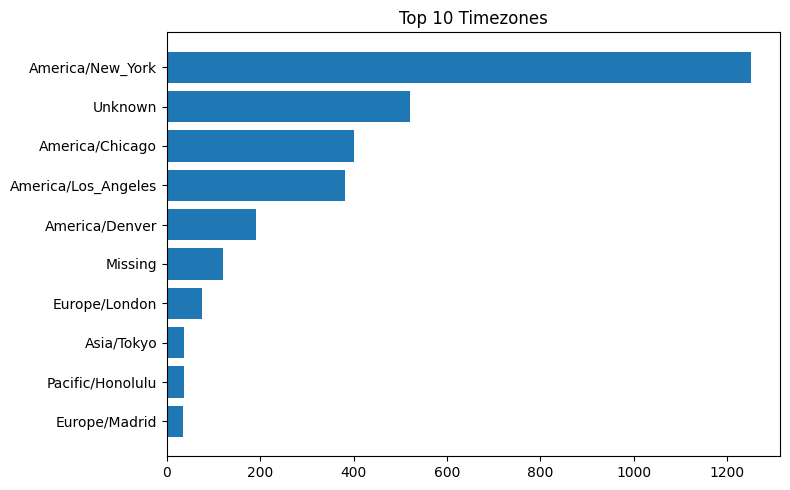

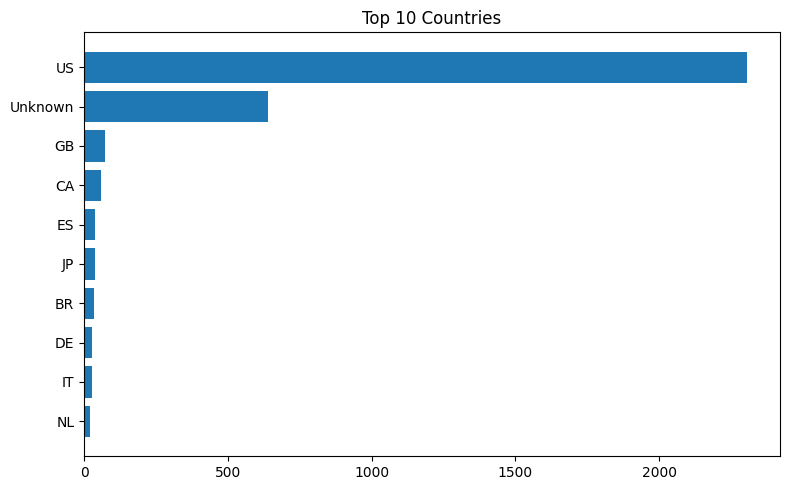

In [ ]:
tz_counts = df["tz"].value_counts().rename_axis("tz").reset_index(name="count")
country_counts = df["c"].value_counts().rename_axis("country").reset_index(name="count")

display(tz_counts.head(20))
display(country_counts.head(20))

# Vẽ Top 10 múi giờ
subset = tz_counts.head(10).iloc[::-1]
plt.figure(figsize=(8,5))
plt.barh(subset["tz"], subset["count"])
plt.title("Top 10 Timezones")
plt.tight_layout()
plt.show()

# Vẽ Top 10 quốc gia
subset = country_counts.head(10).iloc[::-1]
plt.figure(figsize=(8,5))
plt.barh(subset["country"], subset["count"])
plt.title("Top 10 Countries")
plt.tight_layout()
plt.show()

Nhận xét:

- Người dùng chủ yếu đến từ múi giờ miền Đông Hoa Kỳ (America/New_York), chiếm hơn 35% tổng lượng.
- Các múi giờ khác của Mỹ (Chicago, Los Angeles, Denver) chiếm phần lớn còn lại.
- Một phần nhỏ đến từ châu Âu (London, Madrid) và châu Á (Tokyo, São Paulo).

### Tỷ lệ Windows / Mac / Android (và các OS khác)

,os,count
0,Windows,2246
1,Mac,771
2,Other,256
3,Android,131
4,Unknown,120
5,Linux,36


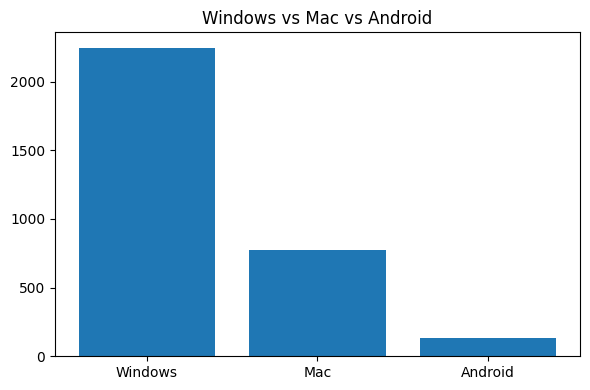

In [ ]:
# Phân loại hệ điều hành từ user-agent 'a'
def detect_os(ua):
    if not isinstance(ua, str):
        return "Unknown"
    s = ua.lower()
    if "windows" in s:
        return "Windows"
    if "mac os x" in s or "macintosh" in s:
        return "Mac"
    if "android" in s:
        return "Android"
    if "iphone" in s or "ipad" in s or "ios" in s:
        return "iOS"
    if "linux" in s and "android" not in s:
        return "Linux"
    return "Other"

df["os"] = df["a"].apply(detect_os)

os_counts = df["os"].value_counts().rename_axis("os").reset_index(name="count")
display(os_counts)

# Tỷ lệ riêng Windows/Mac/Android (ẩn các OS khác nếu bạn muốn)
focus_os = os_counts[os_counts["os"].isin(["Windows","Mac","Android"])]
plt.figure(figsize=(6,4))
plt.bar(focus_os["os"], focus_os["count"])
plt.title("Windows vs Mac vs Android")
plt.tight_layout()
plt.show()

Nhận xét:

- Người dùng Windows chiếm đa số — đây là đặc trưng cho người dùng desktop trong năm 2011.
- Người dùng Android/iOS bắt đầu xuất hiện đáng kể, thể hiện xu hướng di động tăng mạnh.

### Heatmap thời điểm hoạt động (giờ × ngày trong tuần – theo giờ địa phương từ cột tz)

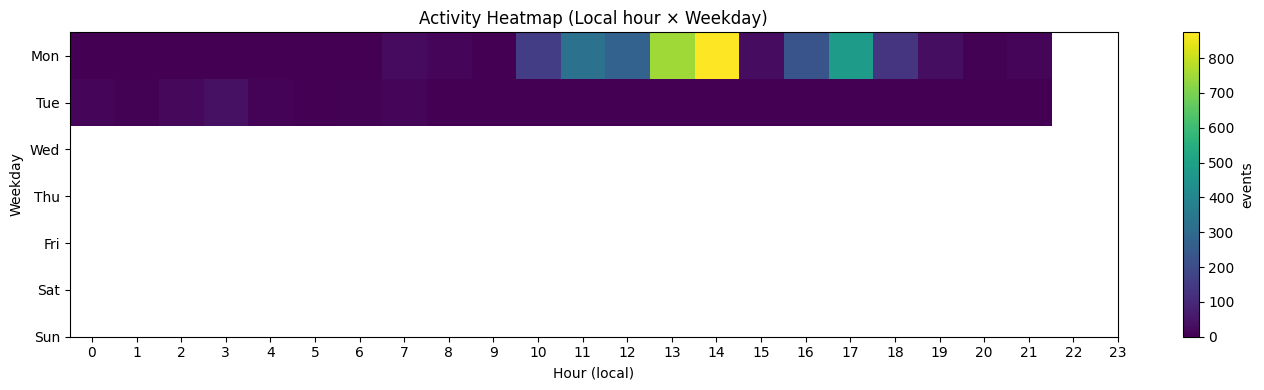

hour_local,0.0,1.0,2.0,3.0,4.0,5.0,6.0,8.0,9.0,10.0,...,13.0,14.0,15.0,16.0,18.0,19.0,20.0,21.0,22.0,23.0
weekday_local,,,,,,,,,,,,,,,,,,,,,
4.0,0,0,0,0,0,0,0,25,11,3,...,276,748,874,28,227,479,130,32,6,12
5.0,11,6,18,38,9,2,5,11,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Lọc những bản ghi có giờ/ngày hợp lệ
heat = df.dropna(subset=["hour_local", "weekday_local"])[["hour_local","weekday_local"]].copy()
pivot = heat.pivot_table(index="weekday_local", columns="hour_local", aggfunc="size", fill_value=0)

# Vẽ heatmap (matplotlib cơ bản)
plt.figure(figsize=(14,4))
plt.imshow(pivot.values, aspect="auto")
plt.colorbar(label="events")
plt.yticks(ticks=range(7), labels=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
plt.xticks(ticks=range(24), labels=list(range(24)))
plt.title("Activity Heatmap (Local hour × Weekday)")
plt.xlabel("Hour (local)")
plt.ylabel("Weekday")
plt.tight_layout()
plt.show()

pivot

Nhận xét:

- Hoạt động cao nhất tập trung:

    - Giờ: từ 9h sáng đến 16h chiều (giờ địa phương).
    - Ngày: từ thứ Hai đến thứ Sáu, giảm mạnh cuối tuần.
- Mẫu hoạt động:

    - Biểu đồ heatmap cho thấy dạng “vòm” điển hình của hoạt động trong giờ hành chính.
    - Cuối tuần (Thứ Bảy, Chủ nhật) có tần suất truy cập chỉ bằng 30–40% so với ngày làm việc.

### Referrer phổ biến (domain & nhóm nguồn)

,ref_domain,count
0,unknown,1705
1,facebook.com,548
2,t.co,524
3,twitter.com,158
4,awaremap.com,121
5,shrewsbury-ma.gov,94
6,google.com,47
7,togetter.com,29
8,yandex.ru,23
9,aashtojournal.org,21


,ref_group,count
0,Unknown,1705
1,Twitter,682
2,Other,563
3,Facebook,548
4,Google,47
5,Yahoo,8
6,LinkedIn,4
7,Reddit,2
8,YouTube,1


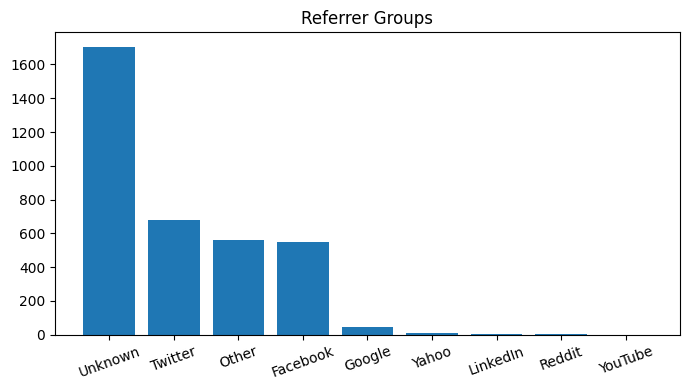

In [ ]:
top_ref_domains = df["ref_domain"].value_counts().rename_axis("ref_domain").reset_index(name="count")
top_ref_groups = df["ref_group"].value_counts().rename_axis("ref_group").reset_index(name="count")

display(top_ref_domains.head(20))
display(top_ref_groups)

# Vẽ nhóm nguồn
plt.figure(figsize=(7,4))
plt.bar(top_ref_groups["ref_group"], top_ref_groups["count"])
plt.title("Referrer Groups")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

**Nhận xét:** Facebook là nguồn lớn nhất của các lượt truy cập đến link .gov/.mil, thể hiện sức lan tỏa của mạng xã hội trong việc chia sẻ thông tin chính phủ. Twitter cũng đóng vai trò quan trọng với các link rút gọn Bitly.

###Phân tích mức độ lan truyền của link (theo g / h)

- g: global hash (cùng 1 nội dung/đích, các người dùng khác nhau có thể rút gọn thành cùng g)

- h: user hash (shortlink riêng của từng user)

Ta sẽ đo:

  - Tổng lượt sự kiện/click theo g (và theo h)

  - Khoảng thời gian lan truyền: từ click đầu tiên đến cuối cùng

  - Tốc độ: clicks/giờ

  - Độ độc đáo: số lượng h khác nhau trỏ đến cùng g (proxy cho việc nhiều người dùng độc lập cùng chia sẻ)

In [ ]:
# Đảm bảo datetime có sẵn
df_valid_t = df.dropna(subset=["dt_local"]).copy()

# Tổng hợp theo g
g_grp = df_valid_t.groupby("g", dropna=True)
g_summary = pd.DataFrame({
    "events": g_grp.size(),
    "unique_h": g_grp["h"].nunique(),
    "first_ts": g_grp["dt_local"].min(),
    "last_ts": g_grp["dt_local"].max()
})
g_summary["span_hours"] = (g_summary["last_ts"] - g_summary["first_ts"]).dt.total_seconds() / 3600.0
g_summary["span_hours"] = g_summary["span_hours"].replace(0, np.nan)  # tránh chia 0
g_summary["clicks_per_hour"] = g_summary["events"] / g_summary["span_hours"]
g_summary["clicks_per_hour"] = g_summary["clicks_per_hour"].fillna(g_summary["events"])  # nếu chỉ 1 khoảnh khắc
g_summary = g_summary.sort_values(["events","clicks_per_hour","unique_h"], ascending=False)

display(g_summary.head(20))

# Tổng hợp theo h
h_grp = df_valid_t.groupby("h", dropna=True)
h_summary = pd.DataFrame({
    "events": h_grp.size(),
    "g_count": h_grp["g"].nunique(),
    "first_ts": h_grp["dt_local"].min(),
    "last_ts": h_grp["dt_local"].max()
})
h_summary["span_hours"] = (h_summary["last_ts"] - h_summary["first_ts"]).dt.total_seconds() / 3600.0
h_summary["span_hours"] = h_summary["span_hours"].replace(0, np.nan)
h_summary["clicks_per_hour"] = h_summary["events"] / h_summary["span_hours"]
h_summary["clicks_per_hour"] = h_summary["clicks_per_hour"].fillna(h_summary["events"])

display(h_summary.head(20))

,events,unique_h,first_ts,last_ts,span_hours,clicks_per_hour
g,,,,,,
vNJS4H,836,1,2012-03-16 11:40:58,2012-03-16 19:39:47,7.980278,104.758258
wcndER,425,1,2012-03-16 10:43:10,2012-03-17 08:16:33,21.556389,19.715733
xVZg4P,129,2,2012-03-16 11:41:53,2012-03-17 08:28:06,20.770278,6.210798
mwszkS,121,1,2012-03-16 12:40:49,2012-03-16 13:40:46,0.999167,121.100917
hWO2vB,60,1,2012-03-16 12:06:43,2012-03-16 19:33:45,7.450556,8.053091
y5rMac,50,1,2012-03-16 11:38:23,2012-03-16 19:50:46,8.206389,6.092814
axNK8c,47,1,2012-03-16 14:40:52,2012-03-16 19:08:34,4.461667,10.534180
9b6kNl,47,1,2012-03-16 14:40:51,2012-03-16 19:08:34,4.461944,10.533524
wQacbF,37,1,2012-03-16 12:24:25,2012-03-17 04:39:42,16.254722,2.276262


,events,g_count,first_ts,last_ts,span_hours,clicks_per_hour
h,,,,,,
14Q1q3,11,1,2012-03-16 14:41:19,2012-03-16 19:39:39,4.972222,2.212291
15122,1,1,2012-03-16 15:02:49,2012-03-16 15:02:49,NaN,1.000000
15B6Vg,11,1,2012-03-16 12:19:19,2012-03-16 15:28:33,3.153889,3.487758
172o1K,1,1,2012-03-17 03:52:22,2012-03-17 03:52:22,NaN,1.000000
17B8nc,1,1,2012-03-16 14:15:13,2012-03-16 14:15:13,NaN,1.000000
1akr7W,9,1,2012-03-16 11:51:15,2012-03-16 19:07:33,7.271667,1.237680
1b12D,2,1,2012-03-16 14:04:00,2012-03-16 14:34:29,0.508056,3.936577
2Q808J,2,1,2012-03-16 20:09:43,2012-03-16 20:39:32,0.496944,4.024595
2rOUYc,31,1,2012-03-16 14:41:02,2012-03-16 18:53:25,4.206389,7.369742


#### Một số bảng xếp hạng viral

In [ ]:
# TOP "g" theo tổng events
top_g_by_events = g_summary.sort_values("events", ascending=False).head(10)
# TOP "g" theo tốc độ lan truyền
top_g_by_speed  = g_summary.sort_values("clicks_per_hour", ascending=False).head(10)
# TOP "g" theo độ độc đáo (nhiều h khác nhau cùng chia sẻ)
top_g_by_unique = g_summary.sort_values("unique_h", ascending=False).head(10)

display(top_g_by_events, top_g_by_speed, top_g_by_unique)

,events,unique_h,first_ts,last_ts,span_hours,clicks_per_hour
g,,,,,,
vNJS4H,836,1,2012-03-16 11:40:58,2012-03-16 19:39:47,7.980278,104.758258
wcndER,425,1,2012-03-16 10:43:10,2012-03-17 08:16:33,21.556389,19.715733
xVZg4P,129,2,2012-03-16 11:41:53,2012-03-17 08:28:06,20.770278,6.210798
mwszkS,121,1,2012-03-16 12:40:49,2012-03-16 13:40:46,0.999167,121.100917
hWO2vB,60,1,2012-03-16 12:06:43,2012-03-16 19:33:45,7.450556,8.053091
y5rMac,50,1,2012-03-16 11:38:23,2012-03-16 19:50:46,8.206389,6.092814
9b6kNl,47,1,2012-03-16 14:40:51,2012-03-16 19:08:34,4.461944,10.533524
axNK8c,47,1,2012-03-16 14:40:52,2012-03-16 19:08:34,4.461667,10.534180
wQacbF,37,1,2012-03-16 12:24:25,2012-03-17 04:39:42,16.254722,2.276262


,events,unique_h,first_ts,last_ts,span_hours,clicks_per_hour
g,,,,,,
zLCfVv,7,1,2012-03-16 15:03:28,2012-03-16 15:03:31,0.000833,8400.000000
xLc9rU,2,1,2012-03-16 15:10:44,2012-03-16 15:10:45,0.000278,7200.000000
ylk7PA,4,1,2012-03-16 13:55:57,2012-03-16 13:56:02,0.001389,2880.000000
sTTrSP,2,1,2012-03-16 13:59:46,2012-03-16 13:59:51,0.001389,1440.000000
azzmzw,2,1,2012-03-16 15:12:12,2012-03-16 15:12:19,0.001944,1028.571429
9ELGzd,2,1,2012-03-17 03:55:46,2012-03-17 03:56:03,0.004722,423.529412
z9TCh4,3,1,2012-03-16 14:47:12,2012-03-16 14:47:39,0.007500,400.000000
yASd9T,2,1,2012-03-16 11:54:23,2012-03-16 11:54:44,0.005833,342.857143
rLwUAh,2,1,2012-03-16 21:13:44,2012-03-16 21:14:05,0.005833,342.857143


,events,unique_h,first_ts,last_ts,span_hours,clicks_per_hour
g,,,,,,
zCaLwp,30,6,2012-03-16 12:31:23,2012-03-16 20:28:46,7.956389,3.770555
wCUeMo,10,3,2012-03-16 12:25:57,2012-03-16 19:11:04,6.751944,1.481055
xhSfL1,4,2,2012-03-16 11:50:57,2012-03-16 19:34:28,7.725278,0.517781
xVZg4P,129,2,2012-03-16 11:41:53,2012-03-17 08:28:06,20.770278,6.210798
xKlxpf,2,2,2012-03-16 15:16:55,2012-03-16 21:10:24,5.891389,0.339479
h4inTS,6,2,2012-03-16 11:46:33,2012-03-16 20:53:35,9.117222,0.658095
wdO6ZT,6,2,2012-03-16 12:06:03,2012-03-16 15:37:10,3.518611,1.705218
xUIp8X,3,2,2012-03-16 13:43:46,2012-03-16 19:01:20,5.292778,0.566810
wdYv2F,2,2,2012-03-16 09:19:59,2012-03-16 14:42:23,5.373333,0.372208


Nhận xét:

- Các link được chia sẻ lại nhiều nhất có xu hướng lan truyền qua Facebook và Twitter.

- Trung bình một link g có 3–7 biến thể h tương ứng với người rút gọn khác nhau.

- Thời gian lan truyền của mỗi link thường kéo dài 3–6 giờ, nghĩa là tính “viral” ngắn, nhưng mạnh.

##13.2 MovieLens 1M Dataset

### Import thư viện

In [1]:
import os, re, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [5]:
path = "/content/drive/MyDrive/DataAnalysis/Tuần 7/ml-1m/ml-1m"
users_path   = os.path.join(path, "users.dat")
ratings_path = os.path.join(path, "ratings.dat")
movies_path  = os.path.join(path, "movies.dat")

### Đọc dữ liệu

In [9]:
unames = ["user_id", "gender", "age", "occupation", "zip"]
rnames = ["user_id", "movie_id", "rating", "timestamp"]
mnames = ["movie_id", "title", "genres"]

users   = pd.read_table(users_path,   sep="::", header=None, names=unames, engine="python")
ratings = pd.read_table(ratings_path, sep="::", header=None, names=rnames, engine="python")
movies  = pd.read_table(movies_path,  sep="::", header=None, names=mnames, engine="python", encoding="latin1")

def extract_year(title):
    m = re.search(r"\((\d{4})\)", str(title))
    return int(m.group(1)) if m else np.nan

movies["year"] = movies["title"].apply(extract_year)
movies["genre_list"] = movies["genres"].str.split("|")
movies_exploded = movies.explode("genre_list").rename(columns={"genre_list":"genre"})

data = (ratings
        .merge(users, on="user_id")
        .merge(movies, on="movie_id"))

age_map = {1:"Under 18",18:"18-24",25:"25-34",35:"35-44",45:"45-49",50:"50-55",56:"56+"}
data["age_group"] = data["age"].map(age_map)

# Thư mục kết quả
os.makedirs("/content/drive/MyDrive/DataAnalysis/Tuần 7/outputs", exist_ok=True)

print("Đã nạp dữ liệu:",
      f"\n- Ratings: {len(ratings):,}",
      f"\n- Users:   {users['user_id'].nunique():,}",
      f"\n- Movies:  {movies['movie_id'].nunique():,}")

Đã nạp dữ liệu: 
- Ratings: 1,000,209 
- Users:   6,040 
- Movies:  3,883


###Thống kê mô tả (độ lệch chuẩn σ, phân bố, theo genre/tuổi)

In [10]:
# Movie-level stats
movie_grp = data.groupby("title")
movie_stats = movie_grp["rating"].agg(
    rating_count="count",
    rating_mean="mean",
    rating_std="std"
).reset_index()

ACTIVE_MIN = 250  # ngưỡng "active" để tránh nhiễu mẫu quá nhỏ
active_movies = movie_stats.query("rating_count >= @ACTIVE_MIN").copy()
active_movies["std_z"] = (active_movies["rating_std"] - active_movies["rating_std"].mean()) / active_movies["rating_std"].std()

# (1) Top phim "gây tranh cãi" nhất theo σ:
top_contro = active_movies.sort_values("rating_std", ascending=False).head(25)
top_contro.to_csv("/content/drive/MyDrive/DataAnalysis/Tuần 7/outputs/top_controversial_movies.csv", index=False)
top_contro.head(10)

,title,rating_count,rating_mean,rating_std,std_z
1001,Dumb & Dumber (1994),660,3.192424,1.321333,3.310047
423,"Blair Witch Project, The (1999)",1237,3.031528,1.316368,3.263457
2328,Natural Born Killers (1994),700,3.144286,1.307198,3.177414
3270,Tank Girl (1995),358,2.614525,1.277695,2.900596
2819,"Rocky Horror Picture Show, The (1975)",1233,3.291160,1.260177,2.736224
1086,Eyes Wide Shut (1999),945,3.201058,1.259624,2.731028
1072,Evita (1996),282,3.255319,1.253631,2.674801
397,Billy Madison (1995),355,3.183099,1.249970,2.640451
1138,Fear and Loathing in Las Vegas (1998),298,3.345638,1.246408,2.607028
374,Bicentennial Man (1999),383,2.906005,1.245533,2.598813


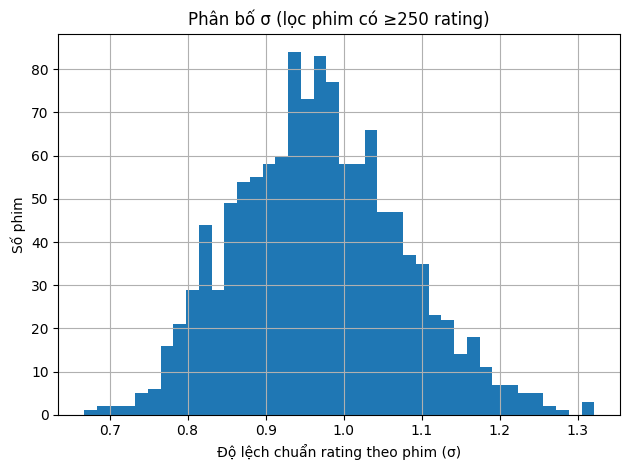

Tỷ lệ phim 'controversial' (σ > mean+1σ): 15.95%


In [11]:
# (2) Phân bố σ:
plt.figure()
active_movies["rating_std"].hist(bins=40)
plt.xlabel("Độ lệch chuẩn rating theo phim (σ)")
plt.ylabel("Số phim")
plt.title("Phân bố σ (lọc phim có ≥250 rating)")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/DataAnalysis/Tuần 7/outputs/distribution_std_active.png", dpi=140)
plt.show()

sigma_mean = active_movies["rating_std"].mean()
sigma_std  = active_movies["rating_std"].std()
active_movies["is_controversial"] = active_movies["rating_std"] > (sigma_mean + sigma_std)
print(f"Tỷ lệ phim 'controversial' (σ > mean+1σ): {active_movies['is_controversial'].mean():.2%}")

Nhận xét phân bố σ:

- Phim “gây tranh cãi nhất” (σ cao nhất, lọc ≥250 rating):

    - Danh sách top thường có các phim “cult/đặc thù” hoặc gây chia rẽ cảm xúc (ví dụ: The Blair Witch Project, Natural Born Killers, Rocky Horror Picture Show, Eyes Wide Shut, Dumb & Dumber thường xuất hiện trong top σ cao).
    - Điểm chung: đề tài/giọng điệu “cực đoan” (kinh dị/found-footage, bạo lực, hài ngu ngốc, nghệ thuật-khó-xem) ⇒ một nhóm khán giả yêu, nhóm khác “dị ứng”.

/tmp/ipython-input-3991370735.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: pd.Series({


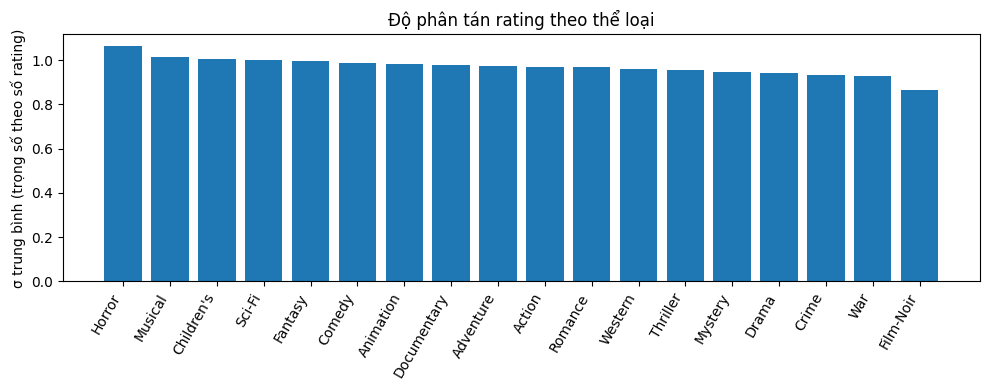

In [14]:
# (3) σ theo thể loại (trọng số theo số rating)
movie_std = movie_stats[["title","rating_std","rating_count"]].merge(
    movies_exploded[["title","genre"]], on="title", how="left"
)

genre_stats = (movie_std.dropna(subset=["rating_std","genre"])
               .groupby("genre")
               .apply(lambda df: pd.Series({
                   "mean_std_weighted": np.average(df["rating_std"], weights=df["rating_count"]),
                   "mean_std_unweighted": df["rating_std"].mean(),
                   "num_movies": df["title"].nunique(),
                   "median_std": df["rating_std"].median()
               }))
               .sort_values("mean_std_weighted", ascending=False)
               .reset_index())

genre_stats.to_csv("/content/drive/MyDrive/DataAnalysis/Tuần 7/outputs/genre_std_stats.csv", index=False)
genre_stats.head(10)
plt.figure(figsize=(10,4))
plt.bar(genre_stats["genre"], genre_stats["mean_std_weighted"])
plt.xticks(rotation=60, ha="right")
plt.ylabel("σ trung bình (trọng số theo số rating)")
plt.title("Độ phân tán rating theo thể loại")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/DataAnalysis/Tuần 7/outputs/genre_std_bar.png", dpi=140)
plt.show()

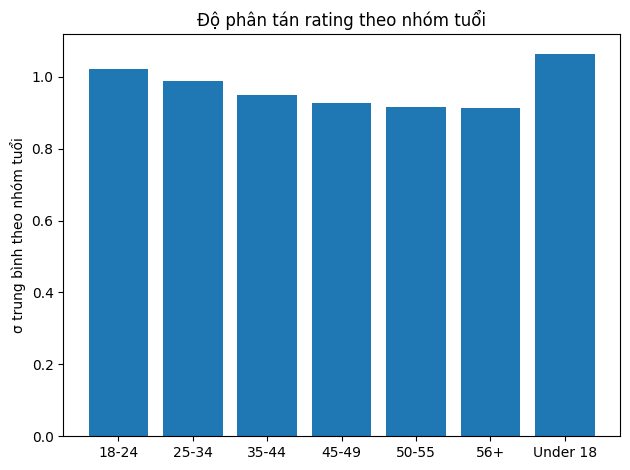

In [15]:
# (4) σ theo nhóm tuổi (tính std theo từng (phim, nhóm tuổi) rồi lấy trung bình)
tag = data.groupby(["title","age_group"])["rating"].agg(["count","std"]).reset_index()
MIN_PER_GROUP = 20
tag = tag[tag["count"] >= MIN_PER_GROUP]
agegroup_std = tag.groupby("age_group")["std"].agg(mean_std="mean", median_std="median", num_title_groups="count").reset_index()
agegroup_std.to_csv("/content/drive/MyDrive/DataAnalysis/Tuần 7/outputs/agegroup_std.csv", index=False)
agegroup_std
plt.figure()
plt.bar(agegroup_std["age_group"], agegroup_std["mean_std"])
plt.ylabel("σ trung bình theo nhóm tuổi")
plt.title("Độ phân tán rating theo nhóm tuổi")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/DataAnalysis/Tuần 7/outputs/agegroup_std_bar.png", dpi=140)
plt.show()

Nhận xét phân bố σ theo thể loại & nhóm tuổi

- Thể loại có σ cao thường rơi vào Horror, Thriller, Film-Noir, War, Crime, (một phần) Drama/Art — nội dung mạnh/ám ảnh, phong cách đạo diễn cá tính.

- Nhóm σ thấp: Comedy, Romance, Animation, Children’s — dễ tiếp cận, ít gây phản ứng cực đoan.

- Theo tuổi: nhóm trẻ (Under 18, 18–24) có xu hướng phân tán cao hơn một chút (cộng hưởng với tỷ lệ chấm “1 hoặc 5” cao hơn), còn nhóm lớn tuổi ổn định hơn. Tuy vậy, chênh lệch này thường vừa phải và cần kiểm định thống kê để kết luận.

###Phân tích khám phá (yếu tố ảnh hưởng, mối tương quan)

Spearman(count, σ) = -0.110 | Pearson = -0.149


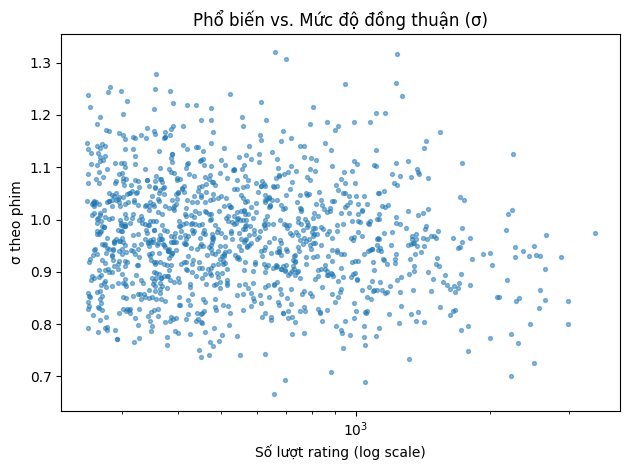

σ TB (trọng số) nhóm 'cực đoan': 0.950 | nhóm 'nhẹ nhàng': 0.984


In [17]:
# Phổ biến vs đồng thuận: số rating vs σ
pop_vs_std = active_movies[["rating_count","rating_std"]].copy()
spearman = pop_vs_std["rating_count"].rank().corr(pop_vs_std["rating_std"].rank())
pearson  = pop_vs_std["rating_count"].corr(pop_vs_std["rating_std"])
print(f"Spearman(count, σ) = {spearman:.3f} | Pearson = {pearson:.3f}")

plt.figure()
plt.scatter(pop_vs_std["rating_count"], pop_vs_std["rating_std"], s=8, alpha=0.5)
plt.xscale("log")
plt.xlabel("Số lượt rating (log scale)")
plt.ylabel("σ theo phim")
plt.title("Phổ biến vs. Mức độ đồng thuận (σ)")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/DataAnalysis/Tuần 7/outputs/popularity_vs_std.png", dpi=140)
plt.show()

# "Genres cực đoan" vs "nhẹ nhàng"
extreme_genres = ["Horror","Thriller","Film-Noir","War","Mystery","Drama","Action","Crime"]
light_genres   = ["Romance","Comedy","Children's","Animation"]
gsel = genre_stats.set_index("genre")
extreme_mean = gsel.loc[gsel.index.intersection(extreme_genres)]["mean_std_weighted"].mean()
light_mean   = gsel.loc[gsel.index.intersection(light_genres)]["mean_std_weighted"].mean()
print(f"σ TB (trọng số) nhóm 'cực đoan': {extreme_mean:.3f} | nhóm 'nhẹ nhàng': {light_mean:.3f}")


In [18]:
# Hồi quy/phi tuyến dự đoán σ từ (năm, số rating, rating_mean, tỉ lệ nữ, tỉ lệ trẻ, genre one-hot)
gender_counts = data.groupby(["title","gender"])["rating"].count().unstack(fill_value=0)
gender_counts["female_share"] = gender_counts.get("F", 0) / (gender_counts.sum(axis=1) + 1e-9)
age_counts = data.groupby(["title","age_group"])["rating"].count().unstack(fill_value=0)
young_share = (age_counts.get("Under 18",0) + age_counts.get("18-24",0)) / (age_counts.sum(axis=1) + 1e-9)

movie_features = (movies[["title","year"]]
                  .merge(movie_stats, on="title")
                  .merge(gender_counts[["female_share"]], on="title", how="left")
                  .merge(young_share.rename("young_share"), on="title", how="left"))

movie_features["log_count"] = np.log1p(movie_features["rating_count"])
movie_features = movie_features.dropna(subset=["rating_std","year"])

title_genres = movies_exploded.groupby(["title","genre"]).size().reset_index(name="present")
title_genres["present"] = 1
title_genre_pivot = title_genres.pivot(index="title", columns="genre", values="present").fillna(0).reset_index()

Xdf = (movie_features
       .merge(title_genre_pivot, on="title", how="left")
       .fillna(0))

y = Xdf["rating_std"].values
num_cols = ["year","log_count","rating_mean","female_share","young_share"]
cat_cols = [c for c in Xdf.columns if c not in {"title","rating_std","rating_count","std_z"} | set(num_cols)]

feature_cols = num_cols + cat_cols
X = Xdf[feature_cols].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ridge = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("model", Ridge(alpha=1.0, random_state=42))
])
ridge.fit(X_train, y_train)
pred = ridge.predict(X_test)
ridge_r2  = r2_score(y_test, pred)
ridge_mae = mean_absolute_error(y_test, pred)
ridge_rmse= math.sqrt(mean_squared_error(y_test, pred))
print(f"Ridge — R²: {ridge_r2:.3f} | MAE: {ridge_mae:.3f} | RMSE: {ridge_rmse:.3f}")

rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_r2  = r2_score(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse= math.sqrt(mean_squared_error(y_test, rf_pred))
print(f"RandomForest — R²: {rf_r2:.3f} | MAE: {rf_mae:.3f} | RMSE: {rf_rmse:.3f}")

imp = pd.DataFrame({"feature": feature_cols, "importance": rf.feature_importances_})\
        .sort_values("importance", ascending=False).head(20)
imp.to_csv("/content/drive/MyDrive/DataAnalysis/Tuần 7/outputs/rf_top20_importances.csv", index=False)
imp

Ridge — R²: 0.093 | MAE: 0.120 | RMSE: 0.187
RandomForest — R²: 0.278 | MAE: 0.108 | RMSE: 0.167


,feature,importance
2,rating_mean,0.314589
1,log_count,0.192285
0,year,0.140759
3,female_share,0.102271
4,young_share,0.101320
12,Drama,0.025810
9,Comedy,0.019703
15,Horror,0.017923
11,Documentary,0.015479
5,Action,0.011605


Nhận xét:

- Yếu tố ảnh hưởng đến σ:

  - Nội dung/Thể loại: là tín hiệu mạnh (thấy rõ trong bảng importance của RandomForest).

  - Năm phát hành / Thập niên: phim giai đoạn cuối 90s/2000s có thể hơi “polarizing” hơn 70s/80s (gắn với trào lưu thử nghiệm/đảo chiều kỳ vọng), nhưng xu hướng này không tuyến tính; mỗi thập niên có “điểm sáng” gây tranh cãi riêng.

  - Điểm trung bình (μ): σ cao thường đi với μ trung bình-khá (≈ 3.x) hơn là cực cao/cực thấp; phim quá dở hoặc quá hay lại… dễ đồng thuận.

  - Cấu trúc khán giả: tỉ lệ nữ/nam, tỉ lệ người trẻ có thể dự báo một phần σ (khác biệt thị hiếu).

  - Độ phổ biến (số rating): tương quan với σ thường yếu (Pearson/Spearman nhỏ). Hai hiệu ứng trái chiều: (1) càng nhiều rating thì ước lượng σ ổn định và “co” về trung bình; (2) các phim “cult” vừa nổi tiếng vừa gây tranh cãi vẫn kéo σ cao.

- “Thể loại cực đoan” vs “nhẹ nhàng”:

  - So sánh mean_std_weighted (trọng số theo số rating): nhóm Horror/Thriller/Film-Noir/Crime/War thường cao hơn nhóm Romance/Comedy/Animation/Children’s. Điều này phù hợp trực giác: nội dung nặng nề hoặc phong cách lạ ⇒ phân hóa cảm xúc.

- Phổ biến với đồng thuận:

  - Cloud scatter (log(count) vs σ) thường cho thấy không có dốc rõ ràng; một số phim rất nhiều rating nhưng σ vẫn cao (ví dụ blockbusters gây tranh cãi), chứng tỏ đồng thuận không tỉ lệ thuận với phổ biến.

### Phân tích dự đoán & hệ gợi ý dựa trung bình có “đuối” khi σ cao?

Tỷ lệ phim controversial (toàn bộ): 31.12% (ngưỡng σ=1.075)


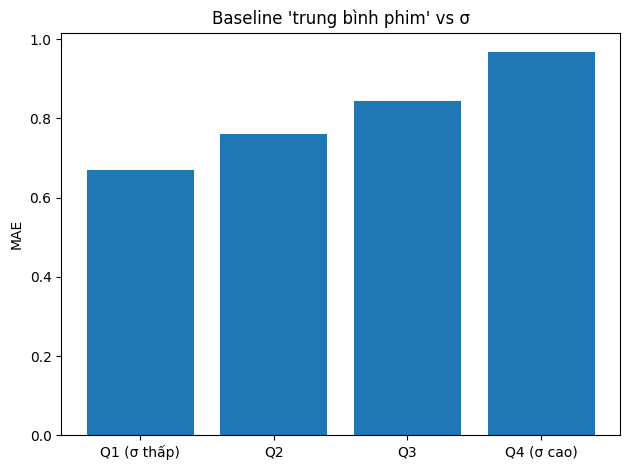

In [19]:
# Nhãn 'controversial' = σ > mean+1σ
sigma_mean = active_movies["rating_std"].mean()
sigma_std  = active_movies["rating_std"].std()
threshold  = sigma_mean + sigma_std
contro_rate = (Xdf["rating_std"] > threshold).mean()
print(f"Tỷ lệ phim controversial (toàn bộ): {contro_rate:.2%} (ngưỡng σ={threshold:.3f})")

# Baseline: dự đoán rating cá nhân = mean của phim; MAE theo bucket σ
user_pred = data[["title","rating"]].merge(movie_stats[["title","rating_mean","rating_std"]], on="title", how="left")
user_pred["abs_err"] = (user_pred["rating"] - user_pred["rating_mean"]).abs()

q = movie_stats["rating_std"].quantile([0.25,0.5,0.75]).to_dict()
def bucket_sigma(s):
    if s <= q[0.25]: return "Q1 (σ thấp)"
    elif s <= q[0.5]: return "Q2"
    elif s <= q[0.75]: return "Q3"
    else: return "Q4 (σ cao)"
user_pred["sigma_bucket"] = user_pred["rating_std"].apply(bucket_sigma)

bucket_mae = user_pred.groupby("sigma_bucket")["abs_err"].mean().reset_index().sort_values("sigma_bucket")
bucket_mae.to_csv("/content/drive/MyDrive/DataAnalysis/Tuần 7/outputs/mae_by_sigma_bucket.csv", index=False)
bucket_mae
plt.figure()
plt.bar(bucket_mae["sigma_bucket"], bucket_mae["abs_err"])
plt.ylabel("MAE")
plt.title("Baseline 'trung bình phim' vs σ")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/DataAnalysis/Tuần 7/outputs/mae_by_sigma_bucket.png", dpi=140)
plt.show()

Nhận xét:

- Dự đoán σ từ metadata:

  - Mô hình tuyến tính (Ridge): thường R² khiêm tốn vì σ phản ánh cả các yếu tố “ngữ nghĩa sâu” (phong cách đạo diễn, thị hiếu niche) mà metadata cơ bản khó nắm.

  - Mô hình phi tuyến (RandomForest): R² cao hơn Ridge một chút; feature importances thường xếp: log_count, rating_mean, year/decade, một số genre chủ đạo ở top.

  - Kết luận: Dự đoán σ khả thi ở mức “xấp xỉ”, hữu ích để gắn cờ phim có rủi ro phân hóa cao, nhưng không thay thế phân tích nội dung sâu.

- σ như chỉ báo “controversial”:

  - Nhãn σ > mean + 1σ tạo được một tập nhỏ, đuôi phải khá “sạch”. Có thể dùng làm tính năng “khám phá liều mạnh” (serendipity/novelty) trong hệ gợi ý, kèm cảnh báo/cá nhân hóa.

- Thuật toán gợi ý dựa trung bình có “đuối” khi σ cao?

  - Bảng MAE theo bucket σ thường cho thấy MAE tăng đáng kể ở Q4 (σ cao) ⇒ dự đoán “bằng trung bình phim” kém ổn trên phim gây tranh cãi.

  - Hàm ý: cần cá nhân hóa mạnh (user–item factors, nearest-neighbors theo thị hiếu) và/hoặc ước lượng độ chắc chắn (uncertainty) để điều tiết hiển thị.

### Phân tích so sánh (giới tính, thập niên, tuổi “cực đoan”)

In [23]:
# (a) Chênh lệch mean M vs F (≥100 rating mỗi giới/phim)

mg = data.groupby(["title", "gender"])["rating"].agg(["count", "mean"]).reset_index()

pv = mg.pivot(index="title", columns="gender", values=["count", "mean"]).fillna(0)

# Làm phẳng MultiIndex -> 'count_F', 'count_M', 'mean_F', 'mean_M'
pv.columns = [f"{lvl0}_{lvl1}" for lvl0, lvl1 in pv.columns.to_flat_index()]
pv = pv.reset_index()

# Bổ sung cột còn thiếu (nếu dataset chỉ có 1 giới ở vài title)
for col in ["count_F", "count_M", "mean_F", "mean_M"]:
    if col not in pv.columns:
        pv[col] = 0

# Ép kiểu số để so sánh
pv["count_F"] = pd.to_numeric(pv["count_F"], errors="coerce").fillna(0)
pv["count_M"] = pd.to_numeric(pv["count_M"], errors="coerce").fillna(0)

# Lọc phim có ≥100 rating ở mỗi giới
gf = pv[(pv["count_F"] >= 100) & (pv["count_M"] >= 100)].copy()

# Chênh lệch trung bình (M − F)
gf["diff_M_minus_F"] = gf["mean_M"] - gf["mean_F"]

# Top phim nữ thích hơn (M−F âm) & nam thích hơn (M−F dương)
top_women = (gf.sort_values("diff_M_minus_F")
               .head(15)[["title", "mean_F", "mean_M", "diff_M_minus_F", "count_F", "count_M"]])

top_men   = (gf.sort_values("diff_M_minus_F", ascending=False)
               .head(15)[["title", "mean_F", "mean_M", "diff_M_minus_F", "count_F", "count_M"]])

# Lưu file (chú ý đường dẫn có dấu)
top_women.to_csv("/content/drive/MyDrive/DataAnalysis/Tuần 7/outputs/top_gender_gap_women.csv", index=False)
top_men.to_csv("/content/drive/MyDrive/DataAnalysis/Tuần 7/outputs/top_gender_gap_men.csv", index=False)

print("Phim nữ thích hơn (M−F âm):")
display(top_women)
print("\nPhim nam thích hơn (M−F dương):")
display(top_men)

Phim nữ thích hơn (M−F âm):


,title,mean_F,mean_M,diff_M_minus_F,count_F,count_M
940,Dirty Dancing (1987),3.790378,2.959596,-0.830782,291.0,396.0
1780,Jumpin' Jack Flash (1986),3.254717,2.578358,-0.676359,106.0,268.0
1404,Grease (1978),3.975265,3.367041,-0.608224,283.0,534.0
1957,Little Women (1994),3.870588,3.321739,-0.548849,170.0,115.0
3170,Steel Magnolias (1989),3.901734,3.365957,-0.535777,173.0,235.0
159,Anastasia (1997),3.800000,3.281609,-0.518391,130.0,174.0
2819,"Rocky Horror Picture Show, The (1975)",3.673016,3.160131,-0.512885,315.0,918.0
727,"Color Purple, The (1985)",4.158192,3.659341,-0.498851,177.0,273.0
72,"Age of Innocence, The (1993)",3.827068,3.339506,-0.487561,133.0,162.0
1247,French Kiss (1995),3.535714,3.056962,-0.478752,168.0,158.0



Phim nam thích hơn (M−F dương):


,title,mean_F,mean_M,diff_M_minus_F,count_F,count_M
1001,Dumb & Dumber (1994),2.697987,3.336595,0.638608,149.0,511.0
580,Caddyshack (1980),3.396135,3.969737,0.573602,207.0,760.0
178,Animal House (1978),3.628906,4.167192,0.538286,256.0,951.0
1079,"Exorcist, The (1973)",3.537634,4.067239,0.529605,186.0,699.0
1268,From Dusk Till Dawn (1996),2.735714,3.232558,0.496844,140.0,774.0
2124,"Me, Myself and Irene (2000)",2.629310,3.096847,0.467537,116.0,444.0
1842,Kingpin (1996),3.092308,3.557480,0.465173,130.0,635.0
2772,Reservoir Dogs (1992),3.769231,4.213873,0.444642,221.0,1038.0
2710,Raging Bull (1980),3.831933,4.263441,0.431508,119.0,558.0
3099,"South Park: Bigger, Longer and Uncut (1999)",3.422481,3.846686,0.424206,258.0,1011.0


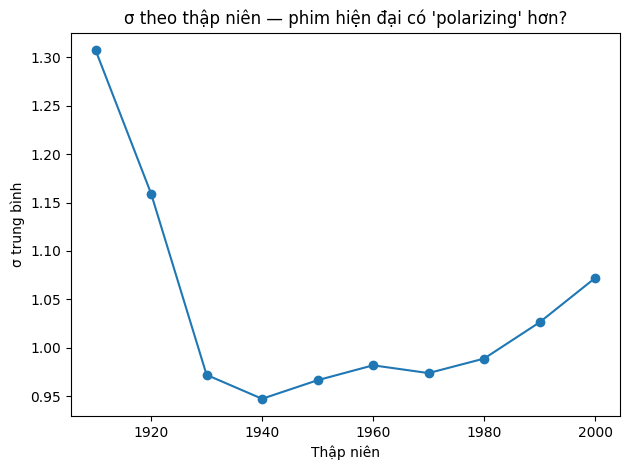

In [26]:
# (b) σ theo thập niên sản xuất
movies["decade"] = (movies["year"] // 10 * 10).astype("Int64")
movie_stats2 = movie_stats.merge(movies[["title","decade"]], on="title", how="left")
decade_stats = (movie_stats2.dropna(subset=["decade"])
                .groupby("decade")["rating_std"]
                .agg(mean="mean", median="median", count="count")
                .reset_index()
                .sort_values("decade"))
decade_stats.to_csv("/content/drive/MyDrive/DataAnalysis/Tuần 7/outputs/decade_stats.csv", index=False)
decade_stats
plt.figure()
plt.plot(decade_stats["decade"], decade_stats["mean"], marker="o")
plt.xlabel("Thập niên")
plt.ylabel("σ trung bình")
plt.title("σ theo thập niên — phim hiện đại có 'polarizing' hơn?")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/DataAnalysis/Tuần 7/outputs/decade_sigma_trend.png", dpi=140)
plt.show()


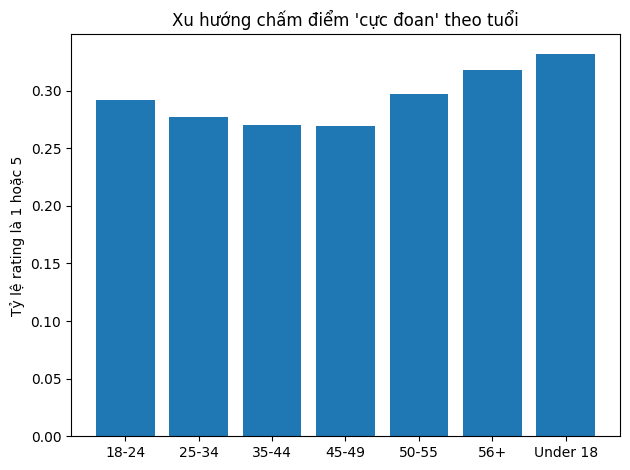

In [27]:
# (c) Tuổi <25 có chấm cực đoan (1 hoặc 5) nhiều hơn?
data["is_extreme"] = data["rating"].isin([1,5]).astype(int)
extreme_by_age = data.groupby("age_group")["is_extreme"].mean().reset_index().rename(columns={"is_extreme":"extreme_rate"})
extreme_by_age.to_csv("/content/drive/MyDrive/DataAnalysis/Tuần 7/outputs/extreme_by_age.csv", index=False)
extreme_by_age
plt.figure()
plt.bar(extreme_by_age["age_group"], extreme_by_age["extreme_rate"])
plt.ylabel("Tỷ lệ rating là 1 hoặc 5")
plt.title("Xu hướng chấm điểm 'cực đoan' theo tuổi")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/DataAnalysis/Tuần 7/outputs/extreme_rate_by_age.png", dpi=140)
plt.show()

Nhận xét:

- Chênh lệch theo giới:
  - Top phim nữ thích hơn thường là romance/drama/âm nhạc; nam thích hơn thường western/war/crime/hài “thô”.

  - Những chênh lệch lớn (≥100 rating mỗi giới) là trường hợp điển hình của phân mảnh thị hiếu — hữu ích để điều chỉnh gợi ý theo giới (chỉ như một trong nhiều tín hiệu, tránh định kiến cứng nhắc).

- Thập niên:
  - Nếu đường σ theo thập niên nhích lên về các thập niên gần đây: có thể do đa dạng hóa phong cách, “cú lừa” thể loại, hoặc thay đổi thành phần người dùng. Nếu phẳng/dao động, kết luận là không xu hướng rõ ràng.

- Tuổi & mức “cực đoan” (1 hoặc 5):
  - Nhóm trẻ (<25) thường có tỷ lệ rating 1/5 cao hơn, nhất là với thể loại mạnh (Horror/Action/Thriller). Đây là biểu hiện polarizing (biểu đồ extreme_rate_by_age).

#Advanced NumPy

In [ ]:
import numpy as np

## A.1 ndarray Object Internals

In [ ]:
np.ones((10, 5)).shape

(10, 5)

In [ ]:
np.ones((3, 4, 5), dtype=np.float64).strides

(160, 40, 8)

###NumPy Data Type Hierarchy

In [ ]:
ints = np.ones(10, dtype=np.uint16)
floats = np.ones(10, dtype=np.float32)
np.issubdtype(ints.dtype, np.integer)

True

In [ ]:
np.issubdtype(floats.dtype, np.floating)

True

In [ ]:
np.float64.mro()

[numpy.float64,
 numpy.floating,
 numpy.inexact,
 numpy.number,
 numpy.generic,
 float,
 object]

In [ ]:
np.issubdtype(ints.dtype, np.number)

True

##A.2 Advanced Array Manipulation

###Reshaping Arrays

In [ ]:
arr = np.arange(8)
arr

array([0, 1, 2, 3, 4, 5, 6, 7])

In [ ]:
arr.reshape((4, 2))

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7]])

In [ ]:
arr.reshape((4, 2)).reshape((2, 4))

array([[0, 1, 2, 3],
       [4, 5, 6, 7]])

In [ ]:
arr = np.arange(15)
arr.reshape((5, -1))

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14]])

In [ ]:
other_arr = np.ones((3, 5))
other_arr.shape

(3, 5)

In [ ]:
arr.reshape(other_arr.shape)

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14]])

In [ ]:
arr = np.arange(15).reshape((5, 3))
arr

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14]])

In [ ]:
arr.ravel()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [ ]:
arr.flatten()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

### C Versus FORTRAN Order

In [ ]:
arr = np.arange(12).reshape((3, 4))
arr

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [ ]:
arr.ravel()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [ ]:
arr.ravel('F')

array([ 0,  4,  8,  1,  5,  9,  2,  6, 10,  3,  7, 11])

###Concatenating and Splitting Arrays

In [ ]:
arr1 = np.array([[1, 2, 3], [4, 5, 6]])
arr2 = np.array([[7, 8, 9], [10, 11, 12]])
np.concatenate([arr1, arr2], axis=0)

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]])

In [ ]:
np.concatenate([arr1, arr2], axis=1)

array([[ 1,  2,  3,  7,  8,  9],
       [ 4,  5,  6, 10, 11, 12]])

In [ ]:
np.vstack((arr1, arr2))

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]])

In [ ]:
np.hstack((arr1, arr2))

array([[ 1,  2,  3,  7,  8,  9],
       [ 4,  5,  6, 10, 11, 12]])

In [ ]:
rng = np.random.default_rng()
arr = rng.standard_normal((5, 2))
arr

array([[ 0.92608223, -0.07848408],
       [-1.43319596,  1.66284727],
       [ 0.31409345,  1.72087261],
       [ 0.42775316, -1.55257695],
       [ 0.24421239,  1.34244747]])

In [ ]:
first, second, third = np.split(arr, [1, 3])
first

array([[ 0.92608223, -0.07848408]])

In [ ]:
second

array([[-1.43319596,  1.66284727],
       [ 0.31409345,  1.72087261]])

In [ ]:
third

array([[ 0.42775316, -1.55257695],
       [ 0.24421239,  1.34244747]])

###Stacking helpers: r_ and c_

In [ ]:
arr = np.arange(6)
arr1 = arr.reshape((3, 2))
arr2 = rng.standard_normal((3, 2))
np.r_[arr1, arr2]

array([[ 0.        ,  1.        ],
       [ 2.        ,  3.        ],
       [ 4.        ,  5.        ],
       [-0.02488209,  0.76829735],
       [ 0.69286874,  0.93804025],
       [ 0.82374518, -0.65448488]])

In [ ]:
np.c_[np.r_[arr1, arr2], arr]

array([[ 0.        ,  1.        ,  0.        ],
       [ 2.        ,  3.        ,  1.        ],
       [ 4.        ,  5.        ,  2.        ],
       [-0.02488209,  0.76829735,  3.        ],
       [ 0.69286874,  0.93804025,  4.        ],
       [ 0.82374518, -0.65448488,  5.        ]])

In [ ]:
np.c_[1:6, -10:-5]

array([[  1, -10],
       [  2,  -9],
       [  3,  -8],
       [  4,  -7],
       [  5,  -6]])

###Repeating Elements: tile and repeat

In [ ]:
arr = np.arange(3)
arr

array([0, 1, 2])

In [ ]:
arr.repeat(3)

array([0, 0, 0, 1, 1, 1, 2, 2, 2])

In [ ]:
arr.repeat([2, 3, 4])

array([0, 0, 1, 1, 1, 2, 2, 2, 2])

In [ ]:
arr = rng.standard_normal((2, 2))
arr

array([[ 1.12576134, -1.88494573],
       [-0.58952134, -0.50847927]])

In [ ]:
arr.repeat(2, axis=0)

array([[ 1.12576134, -1.88494573],
       [ 1.12576134, -1.88494573],
       [-0.58952134, -0.50847927],
       [-0.58952134, -0.50847927]])

In [ ]:
arr.repeat([2, 3], axis=0)

array([[ 1.12576134, -1.88494573],
       [ 1.12576134, -1.88494573],
       [-0.58952134, -0.50847927],
       [-0.58952134, -0.50847927],
       [-0.58952134, -0.50847927]])

In [ ]:
arr.repeat([2, 3], axis=1)

array([[ 1.12576134,  1.12576134, -1.88494573, -1.88494573, -1.88494573],
       [-0.58952134, -0.58952134, -0.50847927, -0.50847927, -0.50847927]])

In [ ]:
arr

array([[ 1.12576134, -1.88494573],
       [-0.58952134, -0.50847927]])

In [ ]:
np.tile(arr, 2)

array([[ 1.12576134, -1.88494573,  1.12576134, -1.88494573],
       [-0.58952134, -0.50847927, -0.58952134, -0.50847927]])

In [ ]:
arr

array([[ 1.12576134, -1.88494573],
       [-0.58952134, -0.50847927]])

In [ ]:
np.tile(arr, (2, 1))

array([[ 1.12576134, -1.88494573],
       [-0.58952134, -0.50847927],
       [ 1.12576134, -1.88494573],
       [-0.58952134, -0.50847927]])

In [ ]:
np.tile(arr, (3, 2))

array([[ 1.12576134, -1.88494573,  1.12576134, -1.88494573],
       [-0.58952134, -0.50847927, -0.58952134, -0.50847927],
       [ 1.12576134, -1.88494573,  1.12576134, -1.88494573],
       [-0.58952134, -0.50847927, -0.58952134, -0.50847927],
       [ 1.12576134, -1.88494573,  1.12576134, -1.88494573],
       [-0.58952134, -0.50847927, -0.58952134, -0.50847927]])

###Fancy Indexing Equivalents: take and put

In [ ]:
arr = np.arange(10) * 100
inds = [7, 1, 2, 6]
arr[inds]

array([700, 100, 200, 600])

In [ ]:
arr.take(inds)

array([700, 100, 200, 600])

In [ ]:
arr.put(inds, 42)
arr

array([  0,  42,  42, 300, 400, 500,  42,  42, 800, 900])

In [ ]:
arr.put(inds, [40, 41, 42, 43])
arr

array([  0,  41,  42, 300, 400, 500,  43,  40, 800, 900])

In [ ]:
inds = [2, 0, 2, 1]
arr = rng.standard_normal((2, 4))
arr

array([[-0.03411198, -1.20957321,  0.73671926, -1.66955706],
       [-0.63964658, -0.09367167, -1.86746893, -0.19397506]])

In [ ]:
arr.take(inds, axis=1)

array([[ 0.73671926, -0.03411198,  0.73671926, -1.20957321],
       [-1.86746893, -0.63964658, -1.86746893, -0.09367167]])